# Adversarial Images for MNIST Classifier
Create adversarial images to fool a MNIST classifier in TensorFlow.

## Introduction

Convolutional Neural Networks acheive near "human level performance" for classifying images. However, they can also be [fooled easily](https://arxiv.org/abs/1312.6199) by introducing a small amount of noise into the image, which is often imperceptible to the human eye. This type of image is sometimes called an adversarial example.

In this short notebook, I will train a MNIST classifier using the [Deep MNIST for Exports] tensorflow tutorial and introduce noise into pictures of '2's that the model will misclassify as '6's.

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
tf.__version__

'0.12.1'

### Load MNIST data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Start Tensorflow Interactive Session

In [4]:
sess = tf.InteractiveSession()

## Create Adversarial variables

### Placeholders

Start by creating placeholders for the input images (x) and output classes (y), which we will feed into our model in batches.

In [5]:
x = tf.placeholder(tf.float32, shape=[None, 28*28], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y')

### Noise Variable

We will create a new variable collections class and variable for the noise.

In [6]:
ADVERSARY_VARIABLES = 'adversary_variables'
collections = [tf.GraphKeys.GLOBAL_VARIABLES, ADVERSARY_VARIABLES]
x_noise = tf.Variable(tf.zeros([28, 28, 1]),
                      name='x_noise', trainable=False,
                      collections=collections)

Return the noise variable name.

In [7]:
adversary_variables = tf.get_collection(ADVERSARY_VARIABLES)
[var.name for var in adversary_variables]

[u'x_noise:0']

## Train the Convolutional Neural Network

### Weight Initialization

In [8]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

### Convolution and Pooling

Our convolutions use a stride of one, are zero padded, and use max pooling over 2x2 blocks.

In [9]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

### First Convolutional Layer

Our first layer will have a convolution followed by max pooling. 'The convolutional will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.'

In [10]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

To apply the layer, we reshape x.

In [11]:
x_image = tf.reshape(x, [-1,28,28,1])

Add the noise to the image. When training using normal optimization, we will set the x_noise to 0.

In [12]:
x_noisy_image = x_image + x_noise

And apply the convolution to the x_image using W_conv1, add the bias, feed through the RELU function, and apply max pooling.

In [13]:
h_conv1 = tf.nn.relu(conv2d(x_noisy_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Second Convolutional Layer

The second layer will have 64 features for each 5x5 patch.

In [14]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### Fully Connected Layer

The fully connected layer takes the $7*7*64$ input, multiples it by weight vector $(7*7*64, 1024)$, adds a bias, and applies a RELU transformation.

In [15]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Apply Dropout

Applying dropout during training introduces regularization by not allowing the model to rely too heavily on certain activations.

In [16]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout Layer

The final layer takes the output of the fully connected layer $(1024, 1)$ and outputs a $(10,1)$ matrix with each element corresponding to a image class.

In [17]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

### Train and evaluate the Model
We will use an adam optimizer (momentum and learning rate decay). 

In [18]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Initialize Variables

In [19]:
sess.run(tf.global_variables_initializer())

### Save Variables
Save the values for the variables after training.

In [20]:
saver = tf.train.Saver()

### Run the Model

Start with 500 iterations of SGD.

In [21]:
for i in range(1000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
# Save the variables to disk.
save_path = saver.save(sess, "/tmp/model.ckpt")
print("Model saved in file: %s" % save_path)

step 0, training accuracy 0.12
step 100, training accuracy 0.84
step 200, training accuracy 0.94
step 300, training accuracy 0.86
step 400, training accuracy 0.98
step 500, training accuracy 0.94
step 600, training accuracy 1
step 700, training accuracy 0.98
step 800, training accuracy 0.88
step 900, training accuracy 1
test accuracy 0.9655
Model saved in file: /tmp/model.ckpt


## Generate Adversarial Images

We will add a matrix of noise with the same dimensions as the image to the image to generate an adversarial image. Lots of the code is taken from this [fantastic tutorial](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/12_Adversarial_Noise_MNIST.ipynb).

### Adversarial Optimizer

The optimizer tries to minimize two functions. The first function is the probability that the input image is of the adversarial target class (in this case, 6). The second function is an l2 loss function which attempts to minimize the difference between our adversarial image and input image. This time, our optimizer optimizes the pixel values for the noise as opposed to the weights of the model. We will set a hyperparameter value for $\lambda$, which controls the weight of our l2 loss function for the optimizer.

In [22]:
noise_l2_lambda = 0.4

Define the l2-loss function.

In [23]:
l2_loss_noise = noise_l2_lambda * tf.nn.l2_loss(x_noise)

Define the loss, which is the sum of the normal optimizer plus the l2_loss_noise optimizer.

In [24]:
loss_adversary = cross_entropy + l2_loss_noise

We can now define the optimizer. Notice that the optimizer updates the adversary_variables, as opposed to updating the weights and biases in our model.

In [25]:
optimizer_adversary = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary, 
                                                                          var_list=adversary_variables)

### Generate Training Examples

In order to train our model to optimize the noise parameters, we want to create a dataset of just '2s'. We will use '2s' from the train dataset of our model.

In [26]:
# create an index of '2s'
label_two = np.zeros(10)
label_two[2] = 1
n_train = len(mnist.train.labels)
index_two = []
for i in range(n_train):
    if np.array_equal(mnist.train.labels[i], label_two):
        index_two.append(i)

# return a dataset of the index
row_idx = np.array(index_two)
images_two = mnist.train.images[row_idx[:, ]]
labels_two = mnist.train.labels[row_idx[:, ]]

### Generate Test Examples
Do the same thing for the test dataset.

In [27]:
n_test = len(mnist.test.labels)
index_two = []
for i in range(n_test):
    if np.array_equal(mnist.test.labels[i], label_two):
        index_two.append(i)

# return a dataset of the index
row_idx = np.array(index_two)
images_two_test = mnist.test.images[row_idx[:, ]]
labels_two_test = mnist.test.labels[row_idx[:, ]]

Create adversarial labels with the class '6'.

In [28]:
# set the adversarial class to 6
adv_labels_two_test = np.zeros_like(labels_two_test)
adv_labels_two_test[:, 6] = 1.0

### Adversarial Batch Function

Next we want to create a batch function to generate batches.

In [29]:
def next_batch(data, labels, batch_size, step):
        # generate an offset
        offset = (step * batch_size) % (data.shape[0] - batch_size)
        
        # generate a minibatch.
        batch_data = data[offset:(offset + batch_size), :]
        batch_labels = labels[offset:(offset + batch_size), :]
        
        return batch_data, batch_labels

### Initialize variables

In [38]:
sess.run(tf.global_variables_initializer())
sess.run(tf.variables_initializer([x_noise]))

### Restore variables from Model

In [39]:
saver.restore(sess, "/tmp/model.ckpt")

### Run the Model

In [40]:
for i in range(1000):
    batch = next_batch(images_two, labels_two, 50, i)
    
    # set the adversarial class to 6
    adv_batch_labels = np.zeros_like(batch[1])
    adv_batch_labels[:, 6] = 1.0
    
    # run the optimizer
    optimizer_adversary.run(feed_dict={x: batch[0], y_: adv_batch_labels, keep_prob: 0.5})
    
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: adv_batch_labels, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

# get the noise
noise = sess.run(x_noise)

# reshape noise
noise_reshaped = noise.reshape(784)
test_noise = np.array([noise_reshaped,]*len(images_two_test))

# add to test images
noisy_image_test = test_noise + images_two_test

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: noisy_image_test, y_: adv_labels_two_test, keep_prob: 1.0}))

step 0, training accuracy 0
step 100, training accuracy 0.74
step 200, training accuracy 0.68
step 300, training accuracy 0.66
step 400, training accuracy 0.8
step 500, training accuracy 0.74
step 600, training accuracy 0.76
step 700, training accuracy 0.86
step 800, training accuracy 0.84
step 900, training accuracy 0.82
test accuracy 1


### Plot the Images

Next, I will plot the test image examples as a 10 row, 3 column grid. The first column holds the original imagse, the second column holds the delta, and the third holds the adversarial images.  I'll start by making a function that plots images in a 10x3 image grid.

I'll start by returning the noise variable array

In [41]:
noise = sess.run(x_noise)

I want to verify that the first 10 sample images will be classifed as 6 before plotting them. I'll add noise to the first 10 sample images in the test set, and then create a list for images to plot.

In [42]:
images_to_plot = []
noisy_images = []

for i in range(10):
    images_to_plot.append(images_two_test[i]) 
    images_to_plot.append(noise)
    noisy_image = np.add(images_two_test[i], noise.reshape(784))
    
    # append noisy image to noisy images array
    noisy_images.append(noisy_image)
    images_to_plot.append(noisy_image)

In [43]:
# convert noisy images to a numpy array
noisy_images = np.array(noisy_images)

# create '6' labels for them
adv_batch_labels_sample = np.zeros([10,10])
adv_batch_labels_sample[:, 6] = 1.0

print(correct_prediction.eval(feed_dict={
    x: noisy_images, y_: adv_batch_labels_sample, keep_prob: 1.0}))

[ True  True  True  True  True  True  True  True  True  True]


Since the model classifies them as true, I'll plot them.

In [44]:
def plot_images(images):
    # Create figure with 10x3 sub-plots.
    fig, axes = plt.subplots(10, 3)
    fig.set_size_inches(5.5, 13.5)
    fig.subplots_adjust(hspace=0, wspace=0)
    
    for i, ax in enumerate(axes.flat):
        # Get the i'th image and reshape the array.
        image = images[i].reshape((28,28))
        
        # Plot image.
        ax.imshow(image,
                  cmap='binary', interpolation='nearest')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    
    plt.show()

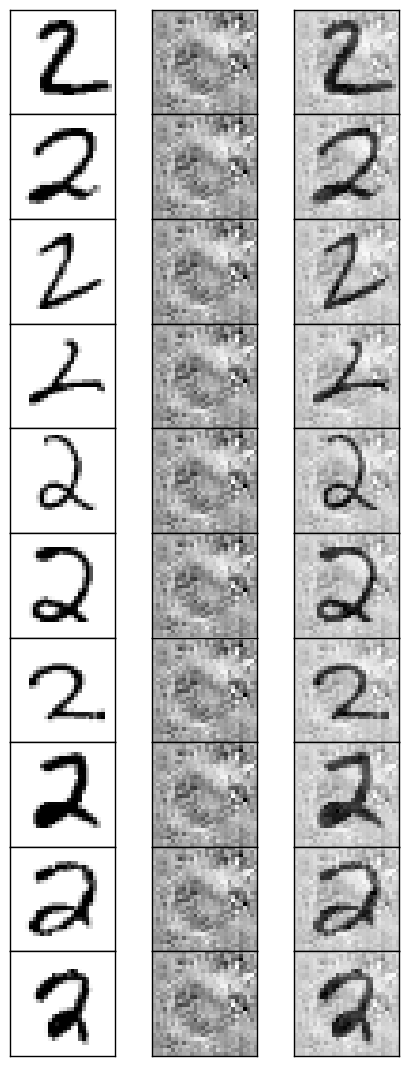

In [45]:
plot_images(images_to_plot)

## Results and Next Steps

By training our model using noise as a parameter we were able to generate images that could fool the classifier but are easily recognized by the human eye. It was interesting for me to learn how to hold certain variables of the model constant and see what the results were by optimizing new variables. I was surprised at how easily the model could be fooled, since classifying numbers using CNN is typically extremely accurate.

There are several things I would do moving forward. First, if I had more time I would increase the number of iterations of gradient descent. I kept it to a minimum so I wouldn't have to wait for the model to finish training. Secondly, I would play around with the hyperparameters, especially the learning rate for the adversarial optimizer.

I also generated the same noise for each image. It would be interesting to explore ways of generating random noise that would fool the classifier.

Also, if we wanted to keep the noise to a minimum we could limit the pixel values that the noise could have.



